In [37]:
import os
import s3fs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# affichage plus lisible
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


### Statistiques descriptives pour la base Taxomony

In [38]:
# 0) Charger la taxonomy
taxo = pd.read_csv(
    "taxonomy.txt",
    sep="\t",
    header=None,
    names=["id_path", "name_path"]
)

print(taxo.shape)
taxo.head()

(5440, 2)


,id_path,name_path
0,1,animals & pet supplies
1,1 > 3237,animals & pet supplies > live animals
2,1 > 2,animals & pet supplies > pet supplies
3,1 > 2 > 3,animals & pet supplies > pet supplies > bird s...
4,1 > 2 > 3 > 7385,animals & pet supplies > pet supplies > bird s...


In [39]:
# 1) Extraire des infos de structure

# Nombre de niveaux (profondeur) dans la hiérarchie
taxo["level"] = taxo["name_path"].str.split(">").str.len()

# Catégorie de niveau 1 (top category)
taxo["top_cat"] = taxo["name_path"].str.split(">").str[0].str.strip()

# Longueur du libellé de catégorie (en nombre de caractères)
taxo["name_len"] = taxo["name_path"].str.len()

taxo[["id_path", "name_path", "level", "top_cat", "name_len"]].head()


,id_path,name_path,level,top_cat,name_len
0,1,animals & pet supplies,1,animals & pet supplies,22
1,1 > 3237,animals & pet supplies > live animals,2,animals & pet supplies,37
2,1 > 2,animals & pet supplies > pet supplies,2,animals & pet supplies,37
3,1 > 2 > 3,animals & pet supplies > pet supplies > bird s...,3,animals & pet supplies,53
4,1 > 2 > 3 > 7385,animals & pet supplies > pet supplies > bird s...,4,animals & pet supplies,77


Statistiques sur la profondeur (level) :
count    5440.000000
mean        4.071875
std         1.013323
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         7.000000
Name: level, dtype: float64

Nombre de catégories par profondeur :
level
1      34
2     191
3    1330
4    2142
5    1323
6     378
7      42
Name: count, dtype: int64


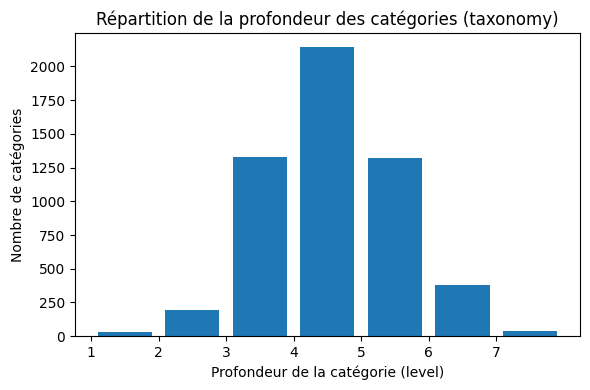

In [40]:
# Stats descriptives sur le nombre de niveaux
print("Statistiques sur la profondeur (level) :")
print(taxo["level"].describe())

# Répartition du nombre de niveaux
level_counts = taxo["level"].value_counts().sort_index()
print("\nNombre de catégories par profondeur :")
print(level_counts)

# Graphe : histogramme du nombre de niveaux
plt.figure(figsize=(6, 4))
taxo["level"].plot(kind="hist", bins=range(1, taxo["level"].max() + 2), rwidth=0.8)
plt.xticks(range(1, taxo["level"].max() + 1))
plt.xlabel("Profondeur de la catégorie (level)")
plt.ylabel("Nombre de catégories")
plt.title("Répartition de la profondeur des catégories (taxonomy)")
plt.tight_layout()
plt.show()


   level  nb_categories  name_len_moy
0      1             34     13.294118
1      2            191     32.963351
2      3           1330     51.499248
3      4           2142     73.521475
4      5           1323    100.916100
5      6            378    130.537037
6      7             42    165.523810


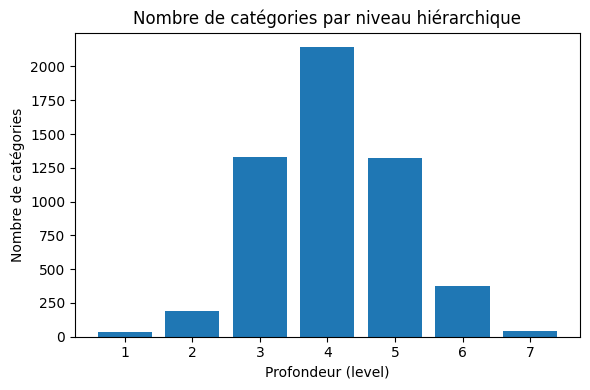

In [41]:
# Tableau : nombre de catégories par niveau
level_table = (
    taxo.groupby("level")
        .agg(nb_categories=("id_path", "count"),
             name_len_moy=("name_len", "mean"))
        .reset_index()
)

print(level_table)

# Graphe : barplot du nombre de catégories par niveau
plt.figure(figsize=(6, 4))
plt.bar(level_table["level"], level_table["nb_categories"])
plt.xlabel("Profondeur (level)")
plt.ylabel("Nombre de catégories")
plt.title("Nombre de catégories par niveau hiérarchique")
plt.tight_layout()
plt.show()


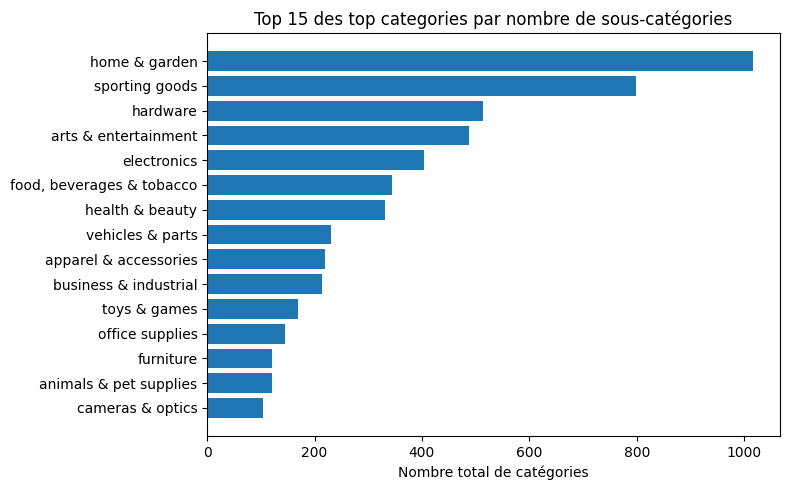

In [42]:
# Stats par top_cat : combien de catégories au total, profondeur moyenne, profondeur max
top_stats = (
    taxo.groupby("top_cat")
        .agg(
            nb_categories=("id_path", "count"),
            level_mean=("level", "mean"),
            level_max=("level", "max")
        )
        .sort_values("nb_categories", ascending=False)
)

top_stats.head(15)

# Graphe : top 15 top_cat les plus riches en catégories
top15 = top_stats.head(15)

plt.figure(figsize=(8, 5))
plt.barh(top15.index, top15["nb_categories"])
plt.gca().invert_yaxis()
plt.xlabel("Nombre total de catégories")
plt.title("Top 15 des top categories par nombre de sous-catégories")
plt.tight_layout()
plt.show()


Nombre de catégories feuilles / non-feuilles :
           nb      freq
is_leaf                
True     4625  0.850184
False     815  0.149816


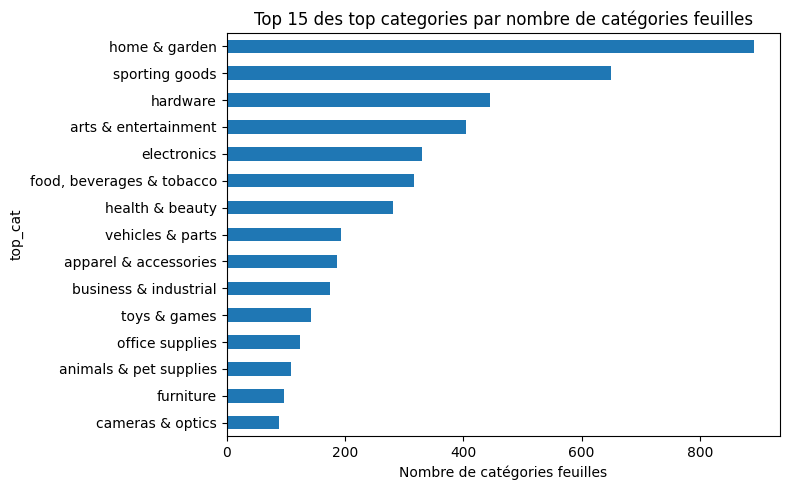

In [59]:
# Construire l'ensemble des chemins qui sont "préfixes" d'autres => ce sont les noeuds non-feuilles
paths = taxo["id_path"].tolist()
prefixes = set()

for p in paths:
    parts = [part.strip() for part in p.split(">")]
    if len(parts) <= 1:
        continue
    cum = parts[0]
    for part in parts[1:]:
        prefixes.add(cum.strip())
        cum = cum + " > " + part.strip()

# is_leaf = True si le chemin complet n'est jamais un préfixe d'un autre chemin
taxo["is_leaf"] = ~taxo["id_path"].isin(prefixes)

taxo["is_leaf"].value_counts()

# Stats sur les feuilles
leaf_stats_global = taxo["is_leaf"].value_counts(normalize=False).rename("nb")
leaf_stats_global_pct = taxo["is_leaf"].value_counts(normalize=True).rename("freq")

print("Nombre de catégories feuilles / non-feuilles :")
print(pd.concat([leaf_stats_global, leaf_stats_global_pct], axis=1))


# Nombre de catégories feuilles par top_cat
leaf_per_top = (
    taxo[taxo["is_leaf"]]
    .groupby("top_cat")["is_leaf"]
    .count()
    .sort_values(ascending=False)
)
leaf_per_top.head(15)

# Graphe : top 15 top_cat avec le plus de feuilles
plt.figure(figsize=(8, 5))
leaf_per_top.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.xlabel("Nombre de catégories feuilles")
plt.title("Top 15 des top categories par nombre de catégories feuilles")
plt.tight_layout()
plt.show()


count    5440.000000
mean       77.671324
std        30.706818
min         5.000000
25%        57.000000
50%        74.000000
75%        94.000000
max       214.000000
Name: name_len, dtype: float64


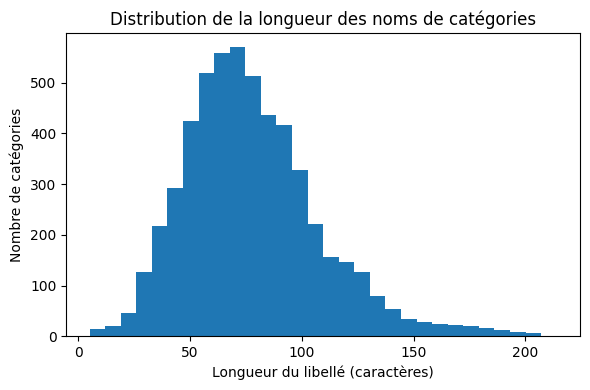

In [60]:
# Stats sur la longueur des libellés
print(taxo["name_len"].describe())

# Graphe : distribution de la longueur des noms
plt.figure(figsize=(6, 4))
taxo["name_len"].plot(kind="hist", bins=30)
plt.xlabel("Longueur du libellé (caractères)")
plt.ylabel("Nombre de catégories")
plt.title("Distribution de la longueur des noms de catégories")
plt.tight_layout()
plt.show()


### Statistiques descriptives du catalogue de Criteo

In [44]:
catalog_df = pd.read_parquet("ensae_export_without_l1.parquet")
catalog_df.head()

,hashed_external_id,title,description,brand,sale_price
0,-2772291400701920348,The Hoodoo Tarot,A divination deck and guidebook rooted in the ...,None,35.0
1,-4184851053829790189,Disney Villains Tarot Deck and Guidebook Movie...,"Let Maleficent, Captain Hook, and other classi...",None,24.99
2,-8778697834751578524,Easy Tarot,"Created especially for beginners, the Easy Tar...",None,19.95
3,-3541475158234224984,The Proudest Blue: A Story of Hijab and Family...,The Instant New York Times Bestseller! A power...,None,17.99
4,-2529310467283008815,The Crystal Magic Tarot: Understand and Contro...,The Crystal Tarot deck and guidebook expands t...,None,24.95


In [45]:
# Taille globale de la base
print("Shape (nb_lignes, nb_colonnes) :", catalog_df.shape)

# Liste des colonnes
print("\nColonnes disponibles :")
print(catalog_df.columns.tolist())

# Aperçu des premières lignes
catalog_df.head()

Shape (nb_lignes, nb_colonnes) : (128253, 5)

Colonnes disponibles :
['hashed_external_id', 'title', 'description', 'brand', 'sale_price']


,hashed_external_id,title,description,brand,sale_price
0,-2772291400701920348,The Hoodoo Tarot,A divination deck and guidebook rooted in the ...,None,35.0
1,-4184851053829790189,Disney Villains Tarot Deck and Guidebook Movie...,"Let Maleficent, Captain Hook, and other classi...",None,24.99
2,-8778697834751578524,Easy Tarot,"Created especially for beginners, the Easy Tar...",None,19.95
3,-3541475158234224984,The Proudest Blue: A Story of Hijab and Family...,The Instant New York Times Bestseller! A power...,None,17.99
4,-2529310467283008815,The Crystal Magic Tarot: Understand and Contro...,The Crystal Tarot deck and guidebook expands t...,None,24.95


In [46]:
print("\nTypes des variables :")
print(catalog_df.dtypes)

print("\nValeurs manquantes (en % par colonne) :")
missing_pct = catalog_df.isna().mean().sort_values(ascending=False) * 100
print(missing_pct.round(2))


Types des variables :
hashed_external_id     int64
title                 object
description           object
brand                 object
sale_price            object
dtype: object

Valeurs manquantes (en % par colonne) :
brand                 12.77
sale_price             0.77
hashed_external_id     0.00
description            0.00
title                  0.00
dtype: float64


In [47]:
n_rows = len(catalog_df)
n_unique_ids = catalog_df["hashed_external_id"].nunique()

print("Nombre de lignes :", n_rows)
print("Nombre d'IDs uniques :", n_unique_ids)
print("Lignes dupliquées sur hashed_external_id :", n_rows - n_unique_ids)

Nombre de lignes : 128253
Nombre d'IDs uniques : 128253
Lignes dupliquées sur hashed_external_id : 0


In [48]:
# Créer des variables de longueur
catalog_df["title_len_chars"] = catalog_df["title"].fillna("").str.len()
catalog_df["title_len_words"] = catalog_df["title"].fillna("").str.split().str.len()

print("\nStatistiques longueur des titres (caractères) :")
print(catalog_df["title_len_chars"].describe())

print("\nStatistiques longueur des titres (mots) :")
print(catalog_df["title_len_words"].describe())


Statistiques longueur des titres (caractères) :
count    128253.000000
mean         60.879613
std          27.031501
min           1.000000
25%          43.000000
50%          56.000000
75%          73.000000
max         222.000000
Name: title_len_chars, dtype: float64

Statistiques longueur des titres (mots) :
count    128253.000000
mean          9.561086
std           4.323048
min           1.000000
25%           7.000000
50%           9.000000
75%          11.000000
max          38.000000
Name: title_len_words, dtype: float64


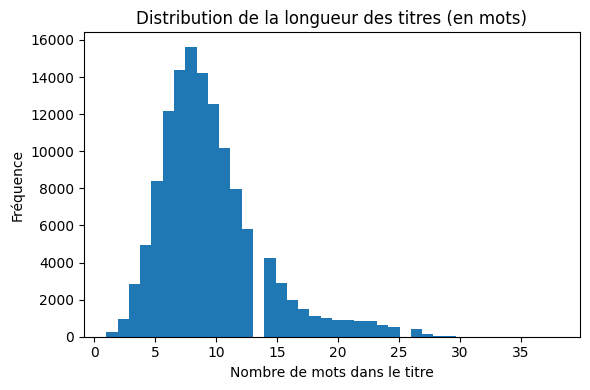

In [49]:
# Histogramme du nb de mots dans le titre
plt.figure(figsize=(6,4))
catalog_df["title_len_words"].plot(kind="hist", bins=40)
plt.xlabel("Nombre de mots dans le titre")
plt.ylabel("Fréquence")
plt.title("Distribution de la longueur des titres (en mots)")
plt.tight_layout()
plt.show()

In [50]:
# Variable booléenne : description manquante ou vide
desc_non_nulle = catalog_df["description"].fillna("")
catalog_df["description_len_chars"] = desc_non_nulle.str.len()
catalog_df["description_len_words"] = desc_non_nulle.str.split().str.len()

print("\nPourcentage de produits sans description (vide ou NaN) :")
pct_no_desc = (catalog_df["description_len_chars"] == 0).mean() * 100
print(round(pct_no_desc, 2), "%")

print("\nStatistiques longueur des descriptions (mots) :")
print(catalog_df["description_len_words"].describe())


Pourcentage de produits sans description (vide ou NaN) :
0.0 %

Statistiques longueur des descriptions (mots) :
count    128253.000000
mean         59.486640
std          40.396239
min           1.000000
25%          33.000000
50%          46.000000
75%          72.000000
max         359.000000
Name: description_len_words, dtype: float64


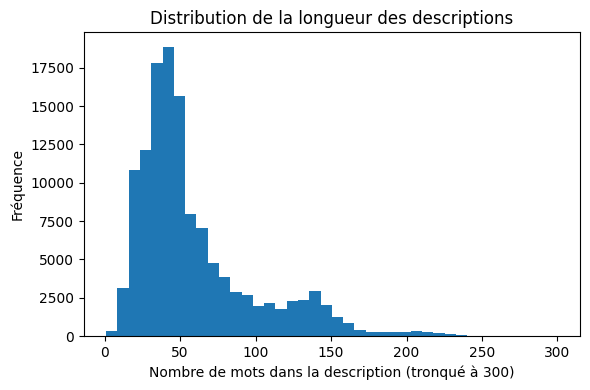

In [51]:
plt.figure(figsize=(6,4))
# On limite aux valeurs raisonnables pour éviter que quelques très longues descriptions écrasent le graphe
subset_desc = catalog_df["description_len_words"].clip(upper=300)
subset_desc.plot(kind="hist", bins=40)
plt.xlabel("Nombre de mots dans la description (tronqué à 300)")
plt.ylabel("Fréquence")
plt.title("Distribution de la longueur des descriptions")
plt.tight_layout()
plt.show()


In [52]:
# Filtrer les valeurs non nulles
price = catalog_df["sale_price"].dropna()

# Conversion en numérique (tout ce qui n'est pas convertible devient NaN)
catalog_df["sale_price"] = pd.to_numeric(catalog_df["sale_price"], errors="coerce")

# Maintenant on peut recréer la série price propre
price = catalog_df["sale_price"].dropna()

print(price.dtype)  # devrait être float64
print(price.describe())


float64
count    127260.000000
mean        281.345232
std         798.223967
min           2.000000
25%          33.180000
50%          75.990000
75%         199.950000
max       35998.000000
Name: sale_price, dtype: float64


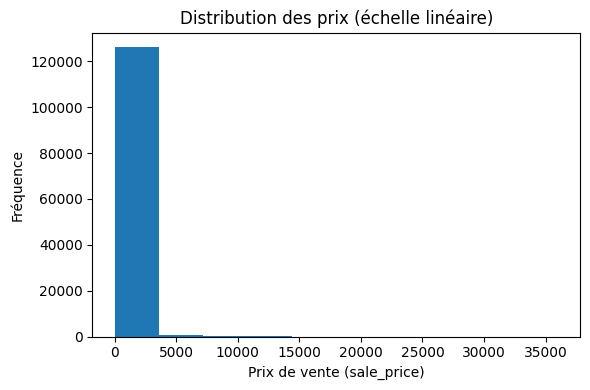

In [53]:
plt.figure(figsize=(6,4))
price.plot(kind="hist", bins=10)
plt.xlabel("Prix de vente (sale_price)")
plt.ylabel("Fréquence")
plt.title("Distribution des prix (échelle linéaire)")
plt.tight_layout()
plt.show()


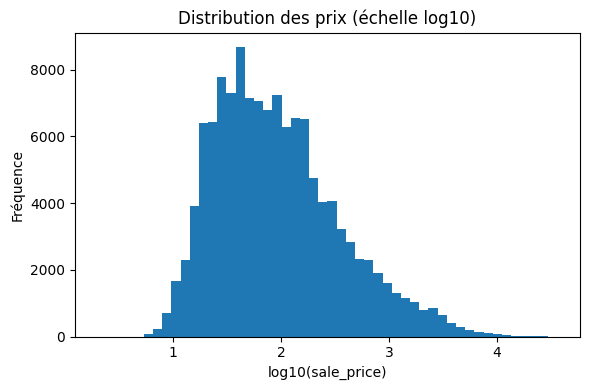

In [54]:
# On garde prix strictement positifs pour le log
price_pos = price[price > 0]
log_price = np.log10(price_pos)

plt.figure(figsize=(6,4))
log_price.plot(kind="hist", bins=50)
plt.xlabel("log10(sale_price)")
plt.ylabel("Fréquence")
plt.title("Distribution des prix (échelle log10)")
plt.tight_layout()
plt.show()

In [55]:
brand = catalog_df["brand"]

print("\nPourcentage de marques manquantes :")
pct_brand_na = brand.isna().mean() * 100
print(round(pct_brand_na, 2), "%")

print("\nNombre de marques distinctes (non nulles) :")
print(brand.dropna().nunique())

print("\nTop 20 des marques les plus fréquentes :")
top_brands = brand.value_counts().head(20)
print(top_brands)



Pourcentage de marques manquantes :
12.77 %

Nombre de marques distinctes (non nulles) :
3970

Top 20 des marques les plus fréquentes :
brand
Macy's             6405
Barnes Noble       3485
Nike               2728
Addison            1484
Costway            1347
Now Foods          1114
Gymax              1067
Sony                970
Dalyn               849
FANATICS            785
Safavieh            686
sugift              677
vidaxl              593
Pyle                576
mitchell & ness     568
New Era             566
tribesigns          536
Wincraft Sports     491
Serta               479
Lands End           455
Name: count, dtype: int64


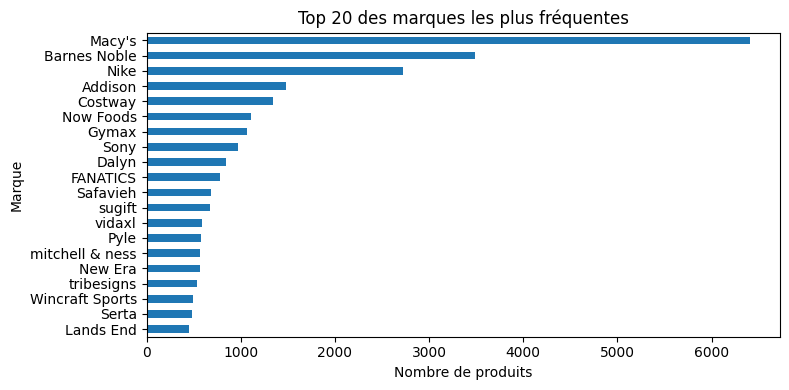

In [56]:
plt.figure(figsize=(8,4))
top_brands.sort_values().plot(kind="barh")
plt.xlabel("Nombre de produits")
plt.ylabel("Marque")
plt.title("Top 20 des marques les plus fréquentes")
plt.tight_layout()
plt.show()


In [57]:
# Résumé texte vs prix
summary_table = pd.DataFrame({
    "title_len_words": catalog_df["title_len_words"].describe(),
    "description_len_words": catalog_df["description_len_words"].describe(),
    "sale_price": price.describe()
})
summary_table


,title_len_words,description_len_words,sale_price
count,128253.000000,128253.000000,127260.000000
mean,9.561086,59.486640,281.345232
std,4.323048,40.396239,798.223967
min,1.000000,1.000000,2.000000
25%,7.000000,33.000000,33.180000
50%,9.000000,46.000000,75.990000
75%,11.000000,72.000000,199.950000
max,38.000000,359.000000,35998.000000
